<a href="https://colab.research.google.com/github/jaderAdriel/Clorofila-a/blob/main/Projeto_pibic_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gspread
!pip install matplotlib

**Import** the library, authenticate, and create the interface to Sheets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from gspread import *
import numpy as np

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

Function to find out the year and campaign according to the title of the worksheet

In [4]:
def get_year_campaign (title):

    title = title.split()
    year = None
    campaing = None

    for digit in title:
        if digit.isnumeric():
            if int(digit) > 2000 and int(digit) < 3000:
                year = digit
            elif int(digit) < 100 and int(digit) > 0:
                campaing = digit

    return year , campaing

In [5]:
def get_years(worksheets):
    years = []
    for worksheet in worksheets:
        year = get_year_campaign(worksheet.title)
        year = year[0]
        if  year not in years:
            years.append(year)

    return sorted(years)

Return a list of worksheets that contains the word especified on the title

In [6]:
def get_worksheet(spreadsheet, word = ' '):

    listOfWorksheet = []

    for worksheet in spreadsheet:
        if word in worksheet.title.split():
            listOfWorksheet.append(worksheet)
            
    return listOfWorksheet


In [7]:
def get_years_campaigns(years):

    years_campaigns = []

    for year in years:
        years_campaigns.append({
        'ano' : str(year),
        'campanha 1' : None,
        'campanha 2' : None,
        'campanha 3' : None,
        'campanha 4' : None,
        })

    return years_campaigns


In [8]:
def valid_value(value):
    
    validValue = ''
    value = str(value)

    for i in value:
        if i == ',':
            validValue += '.'
        elif i == '<':
            validValue += ''
        else:
            validValue += i

    try:
        return float(validValue)
    except:
        return value

In [9]:
def valid_line(years_campaigns):

    empity_nows = []
    for i, yearCampaign in enumerate(years_campaigns):
        condicao = [yearCampaign['campanha 1'] == None,yearCampaign['campanha 2'] == None,
                    yearCampaign['campanha 3'] == None,yearCampaign['campanha 4'] == None]
        
        if condicao[0] and condicao[1] and condicao[2] and condicao[3]:
            empity_nows.append(i)

    empity_nows.sort(reverse=True)

    for i in empity_nows:
        years_campaigns.pop(i)

    return years_campaigns

In [10]:
def get_parameter(parameterName, worksheets, reservatory):

    years = get_years(worksheets)
    years_campaigns = get_years_campaigns(years)

    parameterUnitType, rowParameter, colUnity = [None,None,None]
    for worksheet in worksheets:
        try:
            line = worksheet.find(parameterName).row
            column = worksheet.find(reservatory).col
            information = valid_value(worksheet.cell(line, column).value)
        except:
            information = None

        year, campaign = get_year_campaign(worksheet.title)
        for i, yearCampaign in enumerate(years_campaigns):
            if yearCampaign['ano'] == str(year):
                if information == 'None' or information == 'sem dados':
                    information = None
                else:
                    if not rowParameter and information != None:
                            row = worksheet.find(parameterName).row 
                            col = worksheet.find('Unidade').col
                            parameterUnitType = worksheet.cell(row, col).value
                years_campaigns[i]['campanha '+campaign] = information


    return valid_line(years_campaigns), parameterUnitType


In [11]:
def createGraph(dic, ylabel, title='parametro',  typeOfGraph='2'):
    if typeOfGraph == '1' or str(typeOfGraph).upper() == 'LINHA':
        lineGraph(dic, title, ylabel)
    else:
        subplotsGraph(dic, title, ylabel)

In [12]:
def lineGraph(dic, title, ylabel):
    campanhas = []
    anos = []
    for ano in dic:
        x = 1
        for campanha in ano.keys():
            if not campanha == 'ano':
                if ano[campanha]:
                    campanhas.append(ano[campanha])
                    anos.append(str(ano['ano'])+'.'+str(x))
              
                    x += 1
    x = anos
    y = campanhas
    plt.gcf().set_size_inches(20,8)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.plot(x, y, color='blue')
    plt.scatter(x, y, color='red')


In [13]:
def subplotsGraph(dic, title, ylabel):
    df = pd.DataFrame(dic)
    campanha = {
    'campanha 1' : list(df['campanha 1']),
    'campanha 2' : list(df['campanha 2']), 
    'campanha 3' : list(df['campanha 3']),
    'campanha 4' : list(df['campanha 4']),
    }

    x = np.arange(len(list(df['ano'])))

    fig, ax = plt.subplots()

    largura = 0.2

    campanha1 = ax.bar(x - largura*1.5 , campanha['campanha 1'],largura, label = 'campanha 1',color = 'turquoise')
    campanha2 = ax.bar(x - largura/2, campanha['campanha 2'],largura, label = 'campanha 2',color = 'tomato')
    campanha3 = ax.bar(x + largura/2, campanha['campanha 3'],largura, label = 'campanha 3',color = 'green')
    campanha4 = ax.bar(x + largura*1.5, campanha['campanha 4'],largura, label = 'campanha 4',color = 'blue')

    plt.figure(figsize=(15,10))
    ax.set_title(f'{title} ao longo dos anos')
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.set_xlabel('Anos')
    ax.set_xticks(x)
    ax.set_xticklabels(list(df['ano']))

    plt.show()

In [14]:
url = 'https://docs.google.com/spreadsheets/d/1HxAY4p2IrmsxG5pAedtHASJg2fPxkOeeotw4wU6oqUw/edit?usp=sharing'
spreadsheet = gc.open_by_url(url)
parameter_report = get_worksheet(spreadsheet, 'Campanha')

In [15]:
parameterName = input('Parameter name: ')
reservatory = 'CND-CER-002'

dic, parameterUnitType = get_parameter(parameterName, parameter_report, reservatory)

Parameter name: pH


Grafico: 
1 - Linha
2 - Barras
1


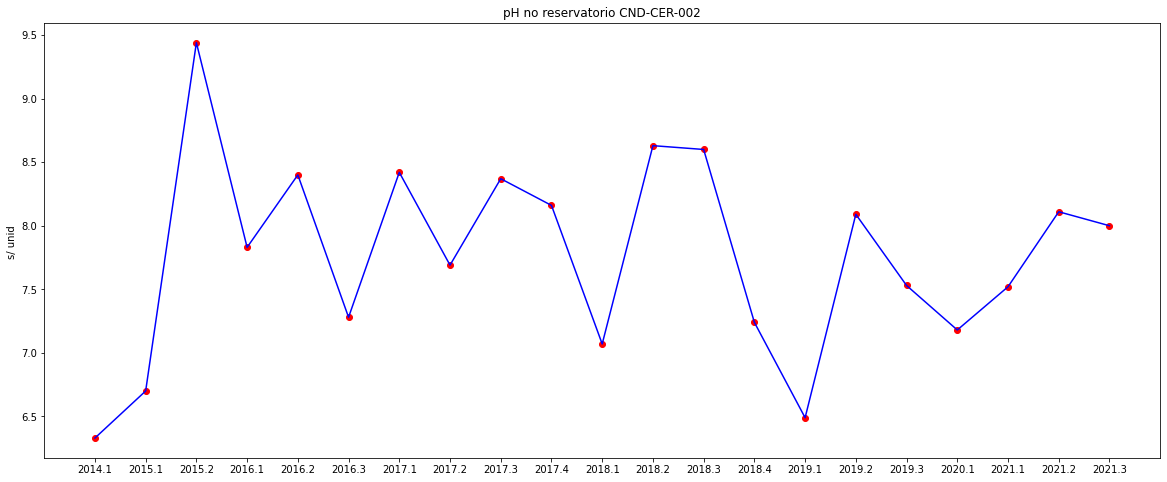

In [17]:
title = f'{parameterName} no reservatorio {reservatory}'
print('Grafico: \n1 - Linha\n2 - Barras')
createGraph(dic, ylabel=parameterUnitType, title= title, typeOfGraph=input())